<a href="https://colab.research.google.com/github/LeyloJohnny/Computational-Neuroscience/blob/main/HMM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HMM Analysis

##Imports

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import scipy.stats as st
import multiprocessing

In [42]:
#get data from google drive
!gdown --id 1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
#unzip data
!unzip 'NewData.zip'

Downloading...
From: https://drive.google.com/uc?id=1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
To: /content/NewData.zip
127MB [00:01, 114MB/s] 
Archive:  NewData.zip
  inflating: Cluster.pkl             
  inflating: BN.pkl                  
  inflating: SFA.pkl                 


In [43]:
!ls

BN.pkl	Cluster.pkl  drive  NewData.zip  sample_data  SFA.pkl


##Access data

In [44]:
#create a list of model name strings
models = ['BN.pkl', "SFA.pkl", "Cluster.pkl"]

#create a list of model names
model_names = ["Balanced Network", "Clustered with SFA", "Clustered wo SFA"]

#create lists to store model data
models_x = []
models_y = []

#for all models
for i in range(len(models)):

  #open pickle file
  with open(models[i], 'rb') as f:
    #get x (actual data: time * neuron id)
    x = pickle.load(f)
    #get y (information on data, such as inhibitory/excitatory neurons, clusters, etc.)
    y = pickle.load(f)
    #add x and y to the models lists
    models_x.append(x)
    models_y.append(y)

##Create raster plot

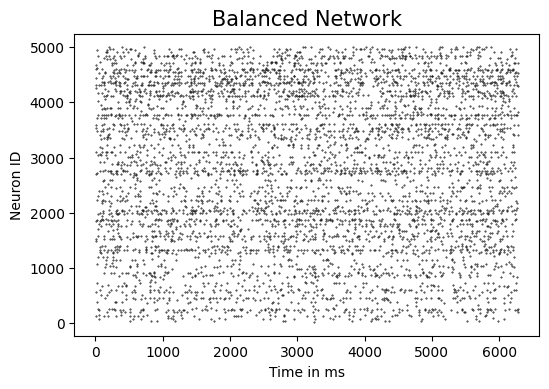

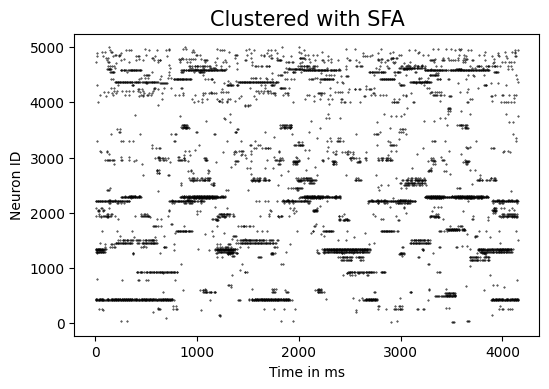

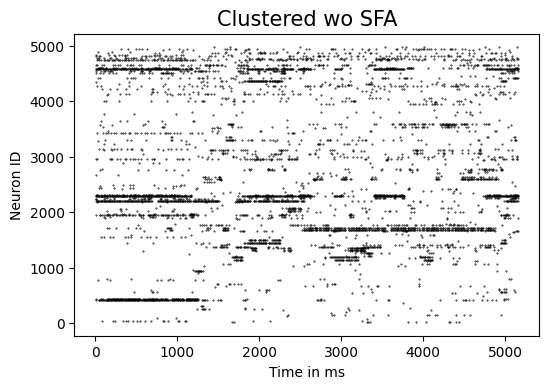

In [52]:
#create list for all three raster plots
rasterplots = []

#for all models
for i in range(len(models)):

  #create figure
  figure = plt.figure(dpi=100)
  #create subplot
  ax = figure.add_subplot(1,1,1)
  #plot both dimensions of x (time, neuron id)
  plt.plot(models_x[i][0][:5000],models_x[i][1][:5000],'.k',markersize = 0.8) 

  #label the plot
  ax.set_xlabel('Time in ms', fontsize = 10)
  ax.set_ylabel('Neuron ID', fontsize = 10)
  ax.set_title(model_names[i], fontsize = 15)

  #store plots in list
  rasterplots.append(figure)


##Create spike count matrix

In [ ]:
#define a time window (in milliseconds)
window = 10

#calculate number of intervals based on recorded time span / time window
intervals = int(np.max(models_x[i][0, :]+ 1)/window)

#define which neurons to focus on (here: only excitatory neurons 0 - 4000)
neurons = int(np.max(models_x[i][1, :])+1) - 1000

#how many intervals do we have?
print("We have " + str(intervals) + " intervals, each " + str(window) + "ms long. \n")

spike_count_matrix = np.zeros((len(models), intervals, neurons))

#for every model
for i in range(len(models)):
  #get the data of the current model
  current_model_x = np.array(models_x[i])

  #create a zeros array with size time * neurons (5000*4000)
  spike_counts = np.zeros((intervals, neurons))

  #for every interval
  for j in range(intervals):

    #get the indices of time points within the current interval
    interval_time_points = np.where(np.logical_and(window*j <= current_model_x[0], current_model_x[0] < window*(j+1)))

    #get data indexed by current interval
    interval_data = current_model_x[1][interval_time_points]
    
    #for every neuron
    for k in range(neurons):

        #get the indices of the current neuron within the defined time interval
        current_neuron = np.where(interval_data == k)

        #get the number of spikes based on the amount of neuron indices within the defined time interval
        spikes = current_neuron[0].shape[0]

        #add spikes number to spike count matrix
        spike_counts[j, k] = spikes
  
  #add spike count matrix for every model
  spike_count_matrix[i] = spike_counts

#print data
print("The spike count matrix has the shape: " + str(spike_count_matrix.shape) + " representing " + 
      str(spike_count_matrix.shape[0]) + " models, " + str(spike_count_matrix.shape[1]) + " intervals, and " + str(spike_count_matrix.shape[2]) + " neurons. \n")
print("Spike count matrix: \n")
print(spike_count_matrix)

In [ ]:
from matplotlib.transforms import offset_copy

if intervals > 5: 
  intervals_to_plot = 5

#initiate figure and axes with specific size, rows = number of models, columns = number of intervals
fig, axes = plt.subplots(figsize= (25, 10), nrows=len(models), ncols=intervals_to_plot)

#define title for columns and rows (intervals and model names)
cols = ['Interval {}'.format(int(col+1)) for col in range(intervals_to_plot)]
rows = ['{}'.format(row) for row in model_names]

#define x and y axes of each subplot (neurons and spike count)
plt.setp(axes.flat, xlabel='neurons', ylabel='spike count')

#define pad (required for spacing between subplots and labels)
pad = 5 # in points

#label columns
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
#labels rows
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#arrange subplots 
fig.tight_layout()
# tight_layout doesn't take labels into account 
# more space needed:
fig.subplots_adjust(left = 0.15, top = 0.95)

#define colors for different models
colors = ['b', 'c', 'g']

#for every interval
for interval in range(intervals_to_plot):
  #for every model
  for model in range(len(models)):
    #make subplots, intervals in columns, models in rows, different color for every model
    #y axis: spike count (based on spike count matrix)
    #x axis: neurons (based on max. neuron id)
    axes[model, interval].plot(range(neurons), spike_count_matrix[model][interval], colors[model])

#show the figure
plt.show()

##Generate dataframe

In [ ]:
#define titles for columns and rows in the dataframe that will be generated from the spike count matrix
cols = ['Neuron{}'.format(int(col+1)) for col in range(neurons)] #rows represent the neurons (= features)
rows = ['Interval{}'.format(int(row+1)) for row in range(intervals)] #columns represent the time intervals/time bins (= samples)

#create list for the data to be analyzed for each model
models_data = []

#for every model
for i in range(len(models)):
  #create a dataframe from the spike count matrix
  current = spike_count_matrix[i]
  data = pd.DataFrame(data = current, index = rows, columns = cols)
  #add the dataframe to the list (containing one dataframe per model)
  models_data.append(data)

#exemplarily show the dataframe for the second model
models_data[2].head(intervals)

###Delete silent neurons

In [ ]:
silent_neurons = []
all_models_silent = []

for model in range(len(models)):
  model_silent_neurons = []
  for neuron in range(neurons):
    if models_data[model].iloc[:, neuron].sum(0) == 0:
      model_silent_neurons.append(neuron+1)
  silent_neurons.append(model_silent_neurons)

In [ ]:
len(silent_neurons[0]), len(silent_neurons[1]), len(silent_neurons[2])

In [ ]:
for model in range(len(models)):
  for neuron_number in range(len(silent_neurons[model])):
    neuron = silent_neurons[model][neuron_number]
    del models_data[model]["Neuron" + str(neuron)]

In [ ]:
models_data[2].head()

In [ ]:
clone_models_data = models_data

In [ ]:
min_neurons = np.min([clone_models_data[0].shape[1], clone_models_data[1].shape[1], clone_models_data[2].shape[1]])

In [ ]:
shortened_data = []

for model in range(len(models)):
  keep_sample = clone_models_data[model].sample(min_neurons, axis = 'columns')
  shortened_data.append(keep_sample)

In [ ]:
shortened_data[2].head(intervals)

In [ ]:
data_list = [models_data, shortened_data]

#HMM

In [ ]:
!pip install git+git://github.com/lindermanlab/ssm
import ssm

In [ ]:
data = shortened_data

#short verion: 10 samples a 2 neurons
n_subsamples = 10
n_neurons = 100
obs_dim = n_neurons

parts = 1

part_length = int(data[1].shape[0]/parts)
time_bins = part_length
print(part_length)

models_subsamples = []

#for all models
for model in range(len(models)):
  #create list for subsamples
  test = data[model]
  current_part_data = []
  models_parts = []
  for part in range(parts): 
    part_start = part*part_length 
    part_end = (part+1)*part_length
    current_part = data[model][part_start:part_end]
    current_part_data.append(current_part)

    #create list for subsamples
    subsamples = []

    #for all subsamples
    for sample in range(n_subsamples):

      sample = current_part.sample(int(n_neurons), axis = 'columns')

      for neuron in range(sample.shape[1]):
        del current_part_data[part][list(sample)[neuron]]
      
      subsamples.append(sample.to_numpy())
    
    models_parts.append(subsamples)

  models_subsamples.append(models_parts)


In [ ]:
synthetic_data = models_subsamples[0][0]

subsamples = len(synthetic_data)
    
#10 different nnumber of latent states
#5-fold cross-validation
#That's 50 model fits! Thankfully this can be parallelized fairly easily
max_states = 10
N_iters = 5
ll_training = np.zeros((max_states,subsamples))
ll_heldout = np.zeros((max_states,subsamples))

train_index = np.arange(0, int(0.8 * synthetic_data[1].shape[1]), 1)
test_index = np.arange(int(0.8 * synthetic_data[1].shape[1]), int(synthetic_data[1].shape[1]), 1)

hmm_z_ms = np.zeros((max_states,time_bins))

#Outer loop over the parameter for which you're doing model selection for
for iS, num_states in enumerate(range(1,max_states+1)):

    #Inner loop over kfolds
    for iK in range(subsamples):

        nTrain = len(train_index); nTest = len(test_index)#*obs_dim
          
        #Split data
        training_data = synthetic_data[iK][train_index]
        test_data = synthetic_data[iK][test_index]
          
        #Create HMM object to fit
        hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

        #fit on training data
        hmm_lls = hmm.fit(training_data, method="em", num_iters=N_iters)#, init_method="kmeans")
          
        #Compute log-likelihood for each dataset
        ll_training[iS,iK] = hmm.log_probability(training_data)/nTrain
        ll_heldout[iS,iK] = hmm.log_probability(test_data)/nTest

In [ ]:
#Plot the log-likelihood of the training and test datasets

fig, axes = plt.subplots(1,2,figsize=(15,5),sharey=False)

#Training data
axes[0].plot(np.arange(1,11),ll_training,'.')
axes[0].plot(np.arange(1,11),np.mean(ll_training,axis=1),'-ok')
axes[0].set_title('Training Log-likelihood')
axes[0].set_ylabel('Log-likelihood / data-point')

axes[1].plot(np.arange(1,11),ll_heldout,'.')
axes[1].plot(np.arange(1,11),np.mean(ll_heldout,axis=1),'-ok')
axes[1].set_title('Test Log-likelihood')

for ax in axes:
    ax.set_xticks(np.arange(1,11))
    ax.set_xlabel('Number of States')
    ax.vlines(5,*ax.get_ylim(),ls='--',color='k')